In [1]:
import tensorflow as tf
import numpy as np
import os
import time
import cv2
from PIL import Image
import datetime

from matplotlib import pyplot as plt
from IPython import display

# **Uploading the training images**

In [ ]:
#upload the training images
from google.colab import files

files.upload()


In [ ]:
!mkdir sidetoside/
!mv *.jpg sidetoside/

# **Setting constants**

In [2]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 400
IMG_HEIGHT = 200

# **Defining the helper functions**

In [3]:
#we load and slice the image in the center thus separating the grayscale and the rgb image
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

In [4]:
#resize and image to our standard
def resize(input_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return input_image

In [5]:
# normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1
  return input_image, real_image

In [6]:
#normalizing the images to [0 , 1]
def normalize2(input_image):
  input_image=(input_image/255)
  return input_image


In [ ]:
#flips some of the images randomly
@tf.function()
def random_jitter(input_image, real_image):

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

In [ ]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [ ]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

**Example of an image**

(200, 400, 3)


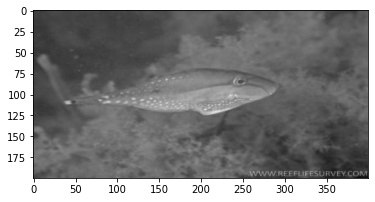

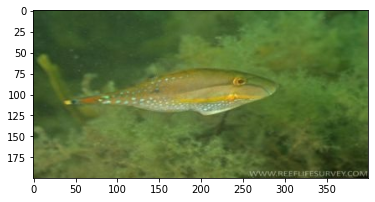

In [ ]:
#showcase an image
inp, re = load('sidetoside/13.jpg')
# casting to int for matplotlib to show the image
print(inp.shape)
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

# **Loading the training dataset**

In [ ]:
train_dataset = tf.data.Dataset.list_files('sidetoside/*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

# **Uploading the test images**

In [ ]:
#upload the test images
from google.colab import files

files.upload()

In [ ]:
!mkdir test/
!mv *.jpg test/

# **Loading the test dataset**

In [ ]:
test_dataset = tf.data.Dataset.list_files('test/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Setting the main layer build for the **models**

In [7]:
OUTPUT_CHANNELS = 3

**Downsample is a three layer setup of Convolution, Batch normaliztion and LeakyRelu**

The downsample decreases the size of the image

In [8]:
def downsample(filters, size,stride, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=stride, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

**Upsample is a four layer setup of Transposed convolution, Batch normaliztion, Dropout and Relu**

The upsample increases the size of the image

In [9]:
def upsample(filters, size,stride, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=stride,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

## Building the Generator


In [10]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[200,400,3])
  #downsample layers
  down_stack = [
    downsample(64, 4,2, apply_batchnorm=False),
    downsample(128, 4,2),
    downsample(128, 4,2), 
    downsample(256, 4,5), 
    downsample(512, 4,5),
  ]
  #upsample layers
  up_stack = [
    upsample(512, 4,5, apply_dropout=True),
    upsample(256, 4,5, apply_dropout=True), 
    upsample(256, 4,2, apply_dropout=True), 
    upsample(128, 4,2), 
    upsample(64, 4,2),
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') 

  x = inputs

  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  #connecting the upsample and the downsample layers
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

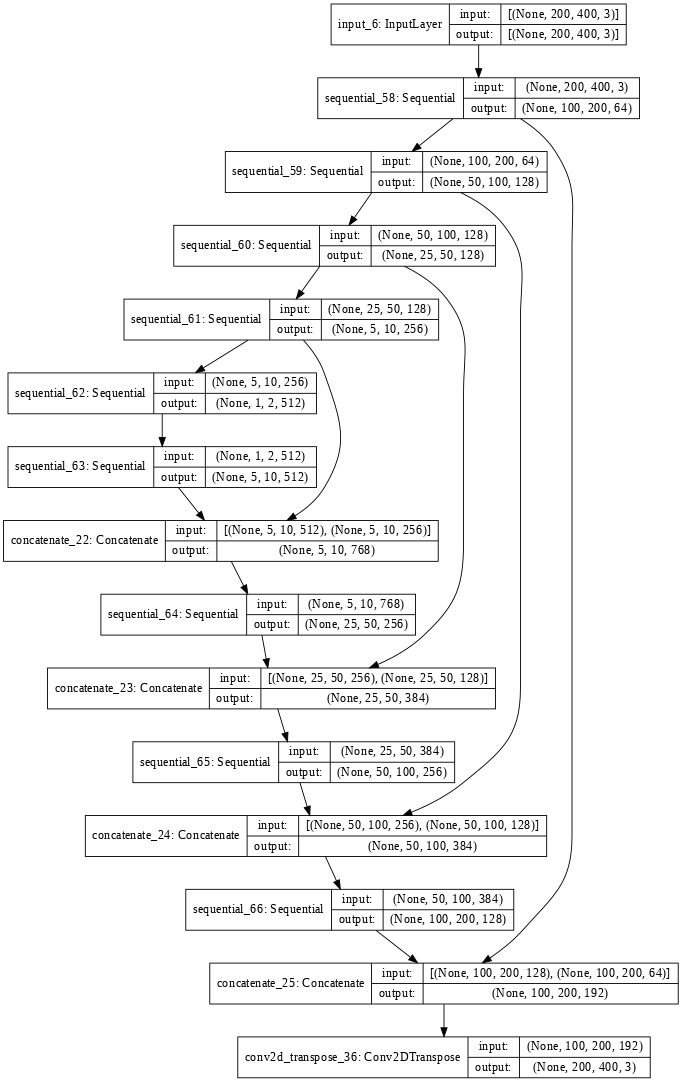

In [ ]:
#visualization of the generator
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

**Generator loss function**

In [ ]:
LAMBDA = 100

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

## Building the Discriminator


In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[200, 400, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[200, 400, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) 

  down1 = downsample(64, 4,2, False)(x) 
  down2 = downsample(128, 4,2)(down1)
  down3 = downsample(256, 4,2)(down2) 

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) 
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) 

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) 

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) 

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

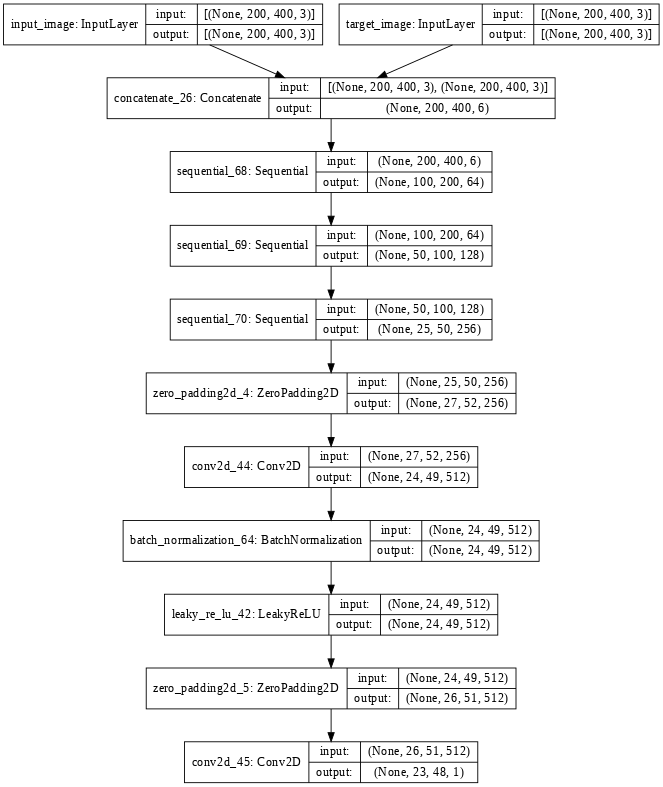

In [ ]:
#visualization of the discriminator
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

**Discriminator loss function**


In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

## Defining the Optimizers


In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Generating Images

In [ ]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

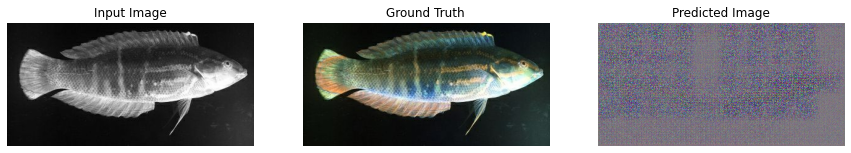

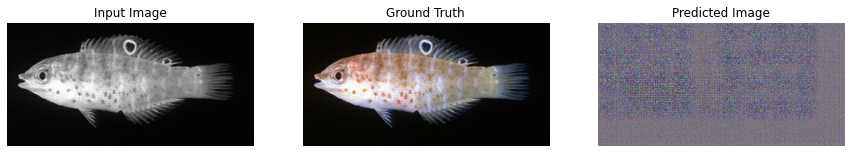

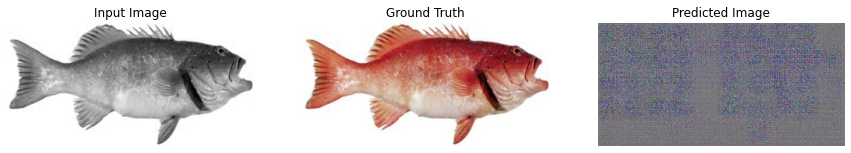

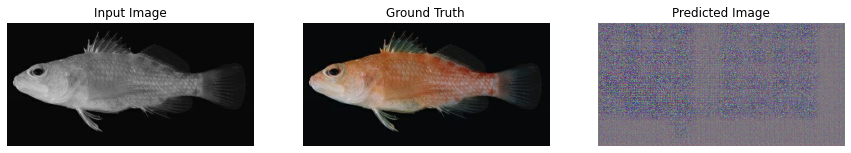

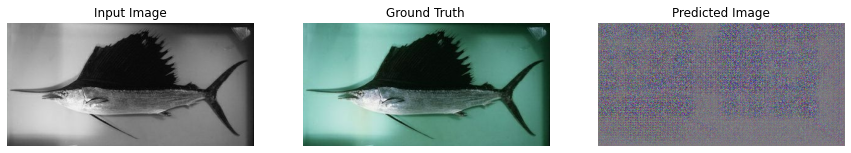

In [ ]:
#example of 5 images on the model for the first time
for example_input, example_target in train_dataset.take(5):
  generate_images(generator, example_input, example_target)

## Training

In [ ]:
EPOCHS = 50

In [ ]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
  
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
  return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss

The actual training loop

In [ ]:

def fit(train_ds, epochs, test_ds):
  X=[]
  Y=[]
  Z=[]
  DISC_LOSS=[]
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      x,y,z,DISCRIM= train_step(input_image, target, epoch)
    X.append(x)
    Y.append(y)
    Z.append(z)
    DISC_LOSS.append(DISCRIM)
    print()

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  return X,Y,Z,DISC_LOSS

Training on the dataset

In [ ]:
x,y,z,DISCRI = fit(train_dataset, EPOCHS, test_dataset)

## **Generator Loss**

In [ ]:
#graph for the generators loss function
plt.xlabel('Epoch Number')
plt.ylabel("Loss Magnitude")
plt.plot(x)



# **Discriminator Loss**

In [ ]:
#graph for the discriminators loss function
plt.xlabel('Epoch Number')
plt.ylabel("Loss Magnitude")
plt.plot(DISCRI)



## Generate using test dataset

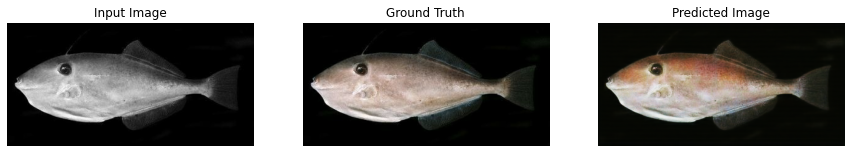

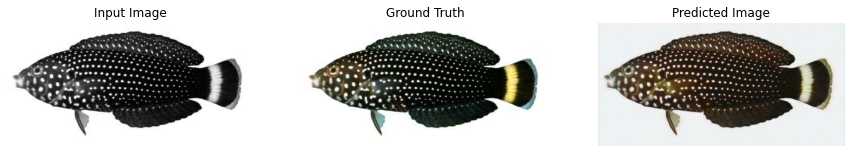

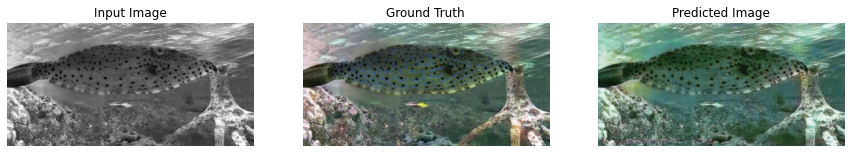

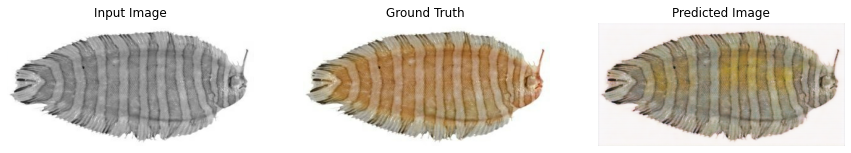

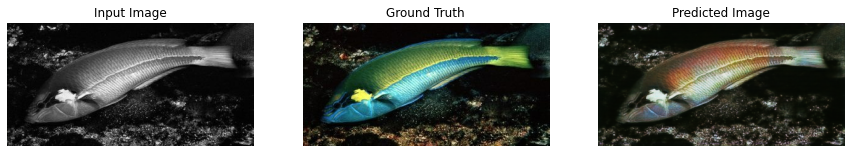

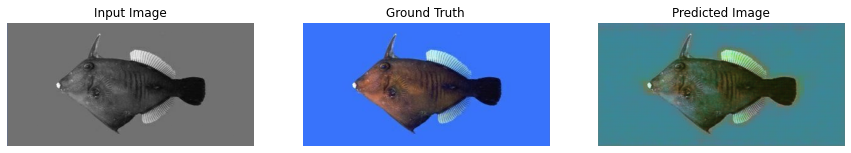

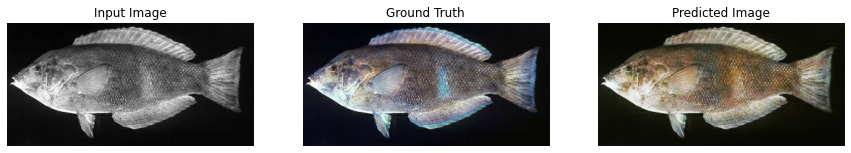

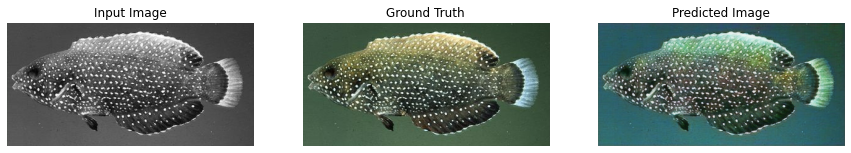

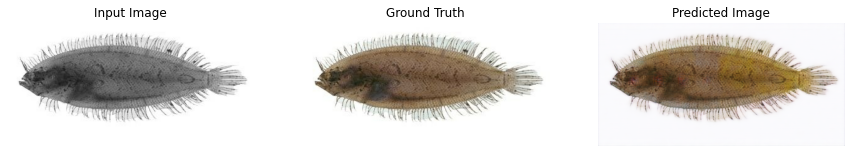

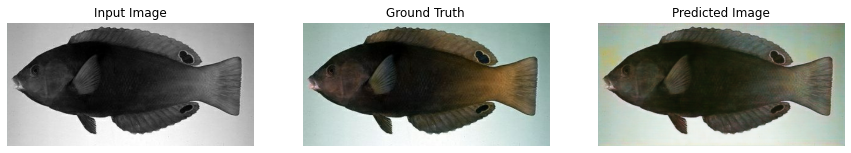

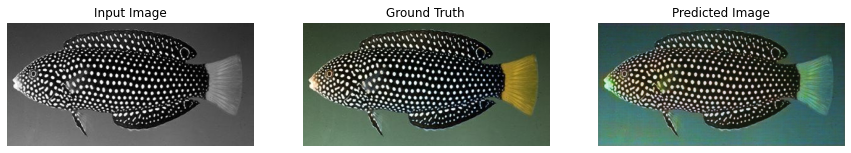

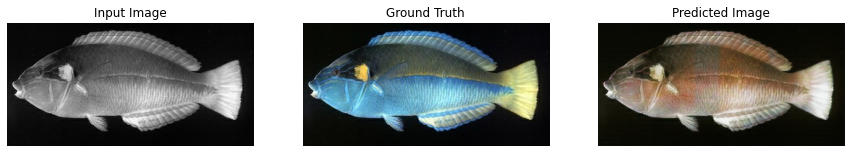

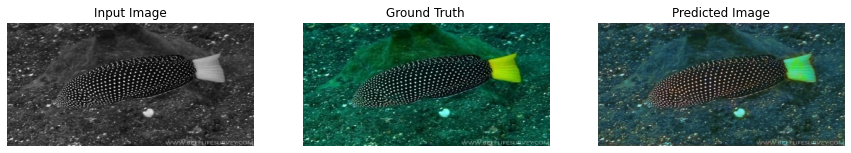

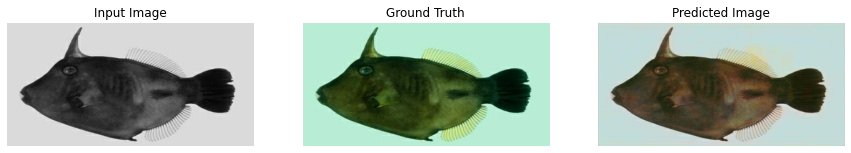

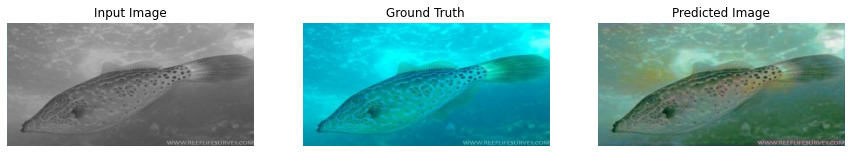

In [ ]:
# Run the trained model on a few examples from the test dataset
for inp, tar in test_dataset.take(15):
  generate_images(generator, inp, tar)

# Upload a grayscale image for colorization

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir single_image
!mv *.jpg single_image/

In [ ]:
!ls single_image/

In [ ]:
model = Generator()
model.load_weights('TrainedModel')

In [17]:
def generate_single_images(model, test_input):
  prediction = model(test_input, training=True) 
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


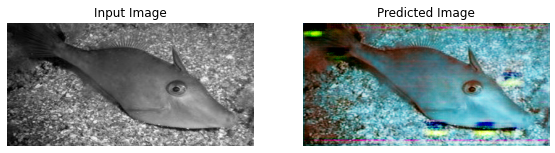

In [22]:
#The image uploaded can be any size and it will resize it to the shape we need
image = tf.io.read_file('/content/single_image/InsertImageNameHere.jpg')
image = tf.image.decode_jpeg(image)
image=tf.cast(image, tf.float32)
image=tf.image.grayscale_to_rgb(image)
image=normalize2(image)
image=resize(image,200,400)
image=tf.expand_dims(image,0)
generate_single_images(model,image)


In [ ]:
#save the model
generator.save_weights('Final')